# Curiosity Sampling Jupyter Notebook

This algorithm, called Curiosity Sampling, is a machine learning-based approach for efficiently sampling the high-dimensional configurational landscape of proteins, which can be difficult to explore using traditional molecular dynamics (MD) simulations. The algorithm seeks to find "novel" areas in the configurational space by maximizing a "curiosity" reward.

In particular, the algorithm focuses on sampling "novel" configurations in the subspace of slow dynamics processes. By doing so, it aims to uncover the pathways between energy valleys and determine the structures of transition state ensembles.

The algorithm can be used with a single initial molecular structure as input, without prior knowledge of the system being studied. Through several test cases, it has been shown to outperform other algorithms commonly used in the computational chemistry community.

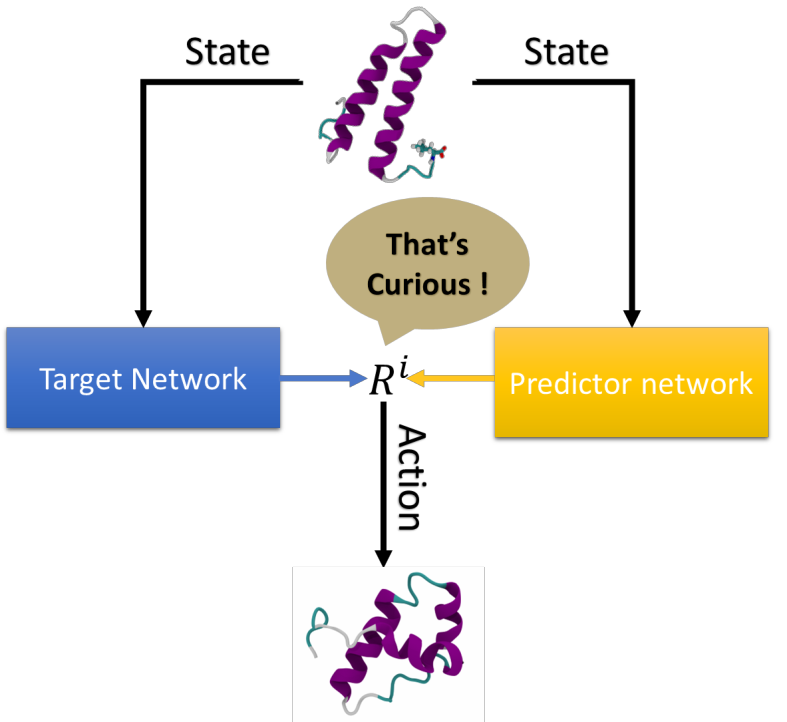

### What will I find in this Jupyter Notebook?
You will learn how to use the Curiosity Sampling algorithm and apply it to the Alanine Dipeptide system. The knowledge can be transferred to any other protein system. 

### Notes
This Jupyter Notebook may differ from the main scripts used to generate data in the main article. It is because it was prepared so that it is easily readable for the reader.

# Initial imports 

Basic imports before we start the journey with Curiosity Sampling 

In [1]:
import os
import copy
# if you want to limit number of GPUs
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Fix random seed

This is for testing purpose only, don't run it if you don't test. If you want to run it, change from Markdown to Code

import random
ALL_RND_SEED = 1

random.seed(ALL_RND_SEED)

import numpy as np

np.random.seed(ALL_RND_SEED)


import tensorflow as tf 

tf.random.set_seed(ALL_RND_SEED)

# Prepare OpenMM molecular system
Here we use Alanine Dipeptide in Implicit solvent from the OpenMMTools package as the molecular system. 

In [2]:
from openmm.app import *
from openmm import *
import openmm
from openmm.unit import *
from openmmtools.testsystems import AlanineDipeptideImplicit




# Creating a simulation with Dialanine
testsystem = AlanineDipeptideImplicit(hydrogenMass=3*amu)
system = testsystem.system
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 4*femtoseconds)
topology = testsystem.topology
positions = testsystem.positions


#save initial pdb structure for a view
filehandle = open('positions.pdb', 'w')
PDBFile.writeHeader(topology, filehandle)
PDBFile.writeModel(topology, positions, filehandle, 0)
PDBFile.writeFooter(topology, filehandle)
filehandle.close()


# Preparing for Curiosity Sampling simulation

## Start Ray instance
To use Curiosity Sampling, we need to start Ray Instance. There are two ways, either you start Ray instance through a terminal, for example as [here for Slurm](https://docs.ray.io/en/latest/cluster/vms/user-guides/community/slurm.html), [here for AWS/GCP/Azure/On-Prem](https://docs.ray.io/en/latest/cluster/vms/user-guides/launching-clusters/index.html) or locally in the Notebook/Python script.

The first one is recommended when you want to use more than one node. For example in a computer center, where you use several nodes to perform calculations. The second one (starting in the Notebook/Python script) is recommended when you want to start your calculations locally or on a single node. 

### Start Ray instance with 6 cores available in total
The number of cores is the number of available cores in your computer. They will be shared automatically.
If you want to use GPUs, you have to add `num_gpus=#`, where `#` is the number of GPUs available for Curiosity Sampling. For example `ray.init(num_cpus=6, num_gpus=1)` or `ray.init(num_cpus=12, num_gpus=2)`.

In [3]:
import ray
# num of cpus on your computer, if you use cuda=True, you have to specify num_of_gpus=1 also
ray.init(num_cpus=6)

{'node_ip_address': '192.168.1.24',
 'raylet_ip_address': '192.168.1.24',
 'redis_address': '192.168.1.24:6379',
 'object_store_address': '/tmp/ray/session_2023-03-21_18-41-46_805865_241938/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2023-03-21_18-41-46_805865_241938/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2023-03-21_18-41-46_805865_241938',
 'metrics_export_port': 55616,
 'gcs_address': '192.168.1.24:40555',
 'node_id': '8cbb872341077d0177963308366495116f9354224bab0b1dcc2c4604'}

## Initialize MD parameters for Curiosity Sampling
Here we set parameters related to the MD simulation, that are used inside Curiosity Sampling to perform MD. In general, the Curiosity Sampling algorithm uses OpenMM underneath to perform MD and most necessary settings are available outside through the `OpenMMManager` class. This class allows to set settings as a number of integrations `steps` per each episode, `saving_frequency` to the file, `reporter_stride` of the MD frames to the **replay buffer**, features used for the **Predictor** and **Target** networks, and if we use `CUDA`, `ROCm HIP` or `CPU`.

In [4]:
from curiositysampling.utils import DEFAULT_OMM_SETTINGS

my_omm_settings = copy.deepcopy(DEFAULT_OMM_SETTINGS)

In [5]:
# set initial positions for all agents. Have to be numpy array (units nm) or Quanity object from OpenMM
my_omm_settings['positions'] = positions
# system object from OpenMM
my_omm_settings['system'] = system
# topology object from OpenMM
my_omm_settings['topology'] = topology
# integrator object from OpenMM
my_omm_settings['integrator'] = integrator
# if to use cuda, if True, HIP have to be False
my_omm_settings['cuda'] = False
# if we want to use ROCm HIP, if True, CUDA have to be False
my_omm_settings['hip'] = False
# number of integration steps per episode. The larger, the better estimation of slow process but sampling becomes worse
# to obtain time, multiply them by the timestep - here it's 200 ps (25k * 0.004 ps)
my_omm_settings['steps'] = 50000
# temperature of the simulation in K
my_omm_settings['temperature'] = 300
# temperature (in K) added to the boosting step
my_omm_settings['boosting_temp'] = 200
# number of intergration steps for boosting, done in a half timestep (if 4 fs was set, 2 fs is used)
my_omm_settings['boosting_steps'] = 5000


### How often do we save to the replay buffer and how often do we save MD trajectory to the file 
The `reporter_stride` controls, how often we save data to the replay buffer for every 1 MD integration. 
For example, if we set `50000` per episode and `reporter_stride=100`, we save `500` frames per episode in total to the replay buffer.
Based on that, also we can calculate the time passed between two frames, generally speaking, $stride \cdot \Delta t$, where $\Delta t = 0.004 ps$ here. So the time is 0.4 ps. 
On the other hand, `saving_frequency` controls how often MD trajectory is saved into DCD files. The two (`saving_frequency` and the first one) don't need to match in value, but the more frequent saving of `reporter_stride` leads to better performance at the cost of memory. 

In [6]:
my_omm_settings['reporter_stride'] = 100
my_omm_settings['saving_frequency'] = 100

### Selection of features
There are three types of features that are fed into Predictor and Target networks
* `use_positions` - uses XYZ positions as features
* `use_distances` - uses contact distances between sidechains as features 
* `use_dihedrals` - uses dihedral angles as features 

To select which atoms are involved in creating these features, we use [MdTraj selection](https://www.mdtraj.org/1.9.8.dev0/atom_selection.html). For example, to select whole protein, you use `protein`. To select only heavy atoms, you will use `all and not type H` (everything, except hydrogens).

In [7]:
# use XYZ coordinates
my_omm_settings['use_positions'] = True
# only heavy atoms
my_omm_settings['selection'] = 'all and not type H'

### Used resources per agent
We can use several GPUs and CPUs per agent for each OpenMM MD simulation. To set it, we use two parameters `gpus_per_agent` and `cpus_per_agent`. 

In [8]:
my_omm_settings['gpus_per_agent'] = None
my_omm_settings['cpus_per_agent'] = 2

### Initialize OpenMMManager with settings above

You pass `my_omm_settings` using dictionary unpacking `**`

In [9]:
from curiositysampling.ray import OpenMMManager

omm = OpenMMManager.remote(**my_omm_settings)

In [10]:
from curiositysampling.utils import DEFAULT_RND_SETTINGS

my_rnd_settings = copy.deepcopy(DEFAULT_RND_SETTINGS)

### Number of slow dynamics processes $k$ and lag time $\tau$
Here we set the number of slow dynamics processes to $k = 2$ and lag time $\tau = 10 ps$. To calculate lag time, we have to calculate the time passed between two frames of MD. The current value in OpenMMmanager is `100`, so if we want a lag time of `4 ps`, we do $stride \cdot \Delta t \cdot \tau_{frames} = \tau$ so it will be $100 \cdot 0.004 ps \cdot \tau_{frames}  = 4 ps <=> \tau_{frames} = 10$. A good approximation for the number of slow dynamics processes is the natural logarithm of number of amino acids **($ln(num_{AA})$)**. With regard to the lagtime, it is usually between **0.5 - 10 ns**, where the larget is the protein, the higher lag time should be used.

We can set weights for each slow dynamics process. This is controlled by the parameter `slowp_vector`. The input is a Python array with float numbers inside. The weights are arranged, so that entry `0` corresponds to the slowest process, and entry `-1` correspond to the fastest. For example `slowp_vector = [1.0, 1.0]` would assume that the first slowest, and second slowest have equal weights. The number of entries has to be an equal number of slow dynamics processes $k$ and so `dense_out`.

In [11]:
# number k of slow processes target network
my_rnd_settings['model']['target']['dense_out'] = 2
# number k of slow processes predictor network
my_rnd_settings['model']['predictor']['dense_out'] = 2
# lag time tau in units of frames
my_rnd_settings['autoencoder_lagtime'] = 10 
# weights for each slow dynamics process when calculating reward, we assume equal
my_rnd_settings['slowp_vector'] = [1.0, 1.0]

### CNN 1D settings
Those settings are not necessary to be adjusted. But in general, it is good to adjust stride and kernel size, especially for smaller systems. We adjust them separately and the options responsible for that are:


* `stride` - an array, where each element corresponds to the stride of a single layer, arranged from the least deep to the deepest one. For example setting stride to `[2, 1, 1]` means that the first layer has stride 2, and the two others have stride 1.
* `kernel_size` - kernel size of each layer, similarly defined as stride. For example setting it to `[3, 3, 1]` means that the first two layers have a kernel size of 3, and the last has a kernel size of 1.


In [12]:
# We set like that because the system is pretty small, so the features can't be strided forever
my_rnd_settings['model']['target']['kernel_size'] = [3, 3, 1]
my_rnd_settings['model']['predictor']['kernel_size'] = [3, 3, 1]
my_rnd_settings['model']['target']['stride'] = [1, 1, 1]
my_rnd_settings['model']['predictor']['stride'] = [1, 1, 1]

The number of fillers for each CNN layer can also be set, but this parameter doesn't affect strongly the performance, except when it is too small or too big. To do so we use the parameter `dense_units`, the same way as `stride` and `kernel_size`.

In [13]:
my_rnd_settings['model']['target']['dense_units'] = [16, 32, 64]
my_rnd_settings['model']['predictor']['dense_units'] = [16, 32, 64]

## Initialize Target and Predictor Networks
Here we focus on the parameters of the Target and Predictor Network. These settings usually stay similar and only a few are changed. We will follow similar pattern as in the case of the OpenMMManager

## Starting Curiosity Sampling simulation 
To start the simulation, we need five things:
* OpenMMManager object, that we have to encapsulate into a dictionary `config_env = {'openmmmanager': my_omm_settings}`
* Target and predictor network settings, that we defined as `my_rnd_settings`
* Number of agents that we want to use
* Number of episodes that we want to run
* Directory where we want to save simulations, Tensorboard data, and tmp files

In [14]:
# we define three parallel actors
number_of_agents = 3
# we will calculate 10 episodes
number_of_episodes = 10
# we will use current directory to save simulation
working_directory = os.getcwd()
# omm object encapsulated
config_env = {'openmmmanager': omm}

In [15]:
from curiositysampling.core import CuriousSampling

# Create CuriositySampling object - it may take a while, as it performs one initial episode
csm = CuriousSampling(rnd_config=my_rnd_settings, env_config=config_env,
                      number_of_agents=number_of_agents, working_directory=working_directory)

 Curiosity Sampling - 2023-03-21 18:41:49,237 :: INFO - Node list :: (curioussampling.py:128)
 Curiosity Sampling - 2023-03-21 18:41:49,243 :: INFO - [{'NodeID': '8cbb872341077d0177963308366495116f9354224bab0b1dcc2c4604', 'Alive': True, 'NodeManagerAddress': '192.168.1.24', 'NodeManagerHostname': 'fst-pct-etu53', 'NodeManagerPort': 33311, 'ObjectManagerPort': 35253, 'ObjectStoreSocketName': '/tmp/ray/session_2023-03-21_18-41-46_805865_241938/sockets/plasma_store', 'RayletSocketName': '/tmp/ray/session_2023-03-21_18-41-46_805865_241938/sockets/raylet', 'MetricsExportPort': 55616, 'alive': True, 'Resources': {'object_store_memory': 7303092633.0, 'node:192.168.1.24': 1.0, 'CPU': 6.0, 'memory': 14606185268.0}}] :: (curioussampling.py:129)
(pid=242193) Warning: importing 'simtk.openmm' is deprecated.  Import 'openmm' instead.
(OpenMMManager pid=242193)  Curiosity Sampling - 2023-03-21 18:41:49,533 :: INFO - OMP_NUM_THREADS is set to 1 while cpus per agent to 2 :: (openmmmanager.py:410)
(Ope

Use default set positions for every agent/walker
Use default set positions for every agent/walker


(SingleBiasedSim pid=242196)  Curiosity Sampling - 2023-03-21 18:41:50,891 :: INFO - Action entering agent 60efa39c-9a4a-4e67-ae37-87072c0d402f is [[ 2.0000010e-01  1.0000000e-01 -1.3000000e-07]
(SingleBiasedSim pid=242196)  [ 2.0000010e-01  2.0900000e-01  1.0000000e-08]
(SingleBiasedSim pid=242196)  [ 1.4862640e-01  2.4538490e-01  8.8982400e-02]
(SingleBiasedSim pid=242196)  [ 1.4862590e-01  2.4538520e-01 -8.8982000e-02]
(SingleBiasedSim pid=242196)  [ 3.4274200e-01  2.6407950e-01 -3.0000000e-07]
(SingleBiasedSim pid=242196)  [ 4.3905800e-01  1.8774060e-01 -6.6000000e-07]
(SingleBiasedSim pid=242196)  [ 3.5553754e-01  3.9696488e-01 -3.1000000e-07]
(SingleBiasedSim pid=242196)  [ 2.7331200e-01  4.5561601e-01 -1.3000000e-07]
(SingleBiasedSim pid=242196)  [ 4.8532621e-01  4.6139253e-01 -4.3000000e-07]
(SingleBiasedSim pid=242196)  [ 5.4075960e-01  4.3155388e-01  8.8981520e-02]
(SingleBiasedSim pid=242196)  [ 5.6613044e-01  4.2208425e-01 -1.2321480e-01]
(SingleBiasedSim pid=242196)  [ 5.1

Use default set positions for every agent/walker


(SingleBiasedSim pid=242192)  Curiosity Sampling - 2023-03-21 18:41:51,193 :: INFO - Action entering agent 9c3f828f-85d2-4638-9a6b-bf395e5c9b43 is [[ 2.0000010e-01  1.0000000e-01 -1.3000000e-07]
(SingleBiasedSim pid=242192)  [ 2.0000010e-01  2.0900000e-01  1.0000000e-08]
(SingleBiasedSim pid=242192)  [ 1.4862640e-01  2.4538490e-01  8.8982400e-02]
(SingleBiasedSim pid=242192)  [ 1.4862590e-01  2.4538520e-01 -8.8982000e-02]
(SingleBiasedSim pid=242192)  [ 3.4274200e-01  2.6407950e-01 -3.0000000e-07]
(SingleBiasedSim pid=242192)  [ 4.3905800e-01  1.8774060e-01 -6.6000000e-07]
(SingleBiasedSim pid=242192)  [ 3.5553754e-01  3.9696488e-01 -3.1000000e-07]
(SingleBiasedSim pid=242192)  [ 2.7331200e-01  4.5561601e-01 -1.3000000e-07]
(SingleBiasedSim pid=242192)  [ 4.8532621e-01  4.6139253e-01 -4.3000000e-07]
(SingleBiasedSim pid=242192)  [ 5.4075960e-01  4.3155388e-01  8.8981520e-02]
(SingleBiasedSim pid=242192)  [ 5.6613044e-01  4.2208425e-01 -1.2321480e-01]
(SingleBiasedSim pid=242192)  [ 5.1

Run the Curiosity Sampling simulation for a `number_of_episodes` episodes

In [16]:
# Run the Curiosity Simulation 
csm.run(number_of_episodes)


 Curiosity Sampling - 2023-03-21 18:43:14,428 :: INFO - Cycle 1 out of 10 cycles :: (curioussampling.py:366)
 Curiosity Sampling - 2023-03-21 18:43:14,433 :: INFO - Current buffer size 0 :: (curioussampling.py:367)
(SingleBiasedSim pid=242197)  Curiosity Sampling - 2023-03-21 18:43:14,545 :: INFO - Action entering agent 3e9145cd-dbc8-4317-8ae1-aa5c8fffbfe9 is [ 98 -42] :: (singlebiasedsim.py:896)
(SingleBiasedSim pid=242196)  Curiosity Sampling - 2023-03-21 18:43:14,845 :: INFO - Action entering agent 60efa39c-9a4a-4e67-ae37-87072c0d402f is [254 -42] :: (singlebiasedsim.py:896)
(SingleBiasedSim pid=242192)  Curiosity Sampling - 2023-03-21 18:43:15,150 :: INFO - Action entering agent 9c3f828f-85d2-4638-9a6b-bf395e5c9b43 is [ 25 -42] :: (singlebiasedsim.py:896)
 Curiosity Sampling - 2023-03-21 18:44:47,721 :: INFO - Lagged AE training buffer current size is: 3000 :: (rndtrain.py:1139)
 Curiosity Sampling - 2023-03-21 18:44:47,721 :: INFO - Timescales for this epoch: [4.790747  1.1208267]

 Curiosity Sampling - 2023-03-21 18:48:37,959 :: INFO - Current buffer size 3 :: (curioussampling.py:367)
(SingleBiasedSim pid=242197)  Curiosity Sampling - 2023-03-21 18:48:38,069 :: INFO - Action entering agent 3e9145cd-dbc8-4317-8ae1-aa5c8fffbfe9 is [[85 85]] :: (singlebiasedsim.py:896)
(SingleBiasedSim pid=242196)  Curiosity Sampling - 2023-03-21 18:48:38,371 :: INFO - Action entering agent 60efa39c-9a4a-4e67-ae37-87072c0d402f is [[341 341]] :: (singlebiasedsim.py:896)
(SingleBiasedSim pid=242192)  Curiosity Sampling - 2023-03-21 18:48:38,675 :: INFO - Action entering agent 9c3f828f-85d2-4638-9a6b-bf395e5c9b43 is [[92 92]] :: (singlebiasedsim.py:896)
 Curiosity Sampling - 2023-03-21 18:50:28,171 :: INFO - Lagged AE training buffer current size is: 7500 :: (rndtrain.py:1139)
 Curiosity Sampling - 2023-03-21 18:50:28,216 :: INFO - Predictor Network reiinitialized :: (rndtrain.py:1184)
 Curiosity Sampling - 2023-03-21 18:50:28,217 :: INFO - Target model updated!!! :: (rndtrain.py:1185

(SingleBiasedSim pid=242192)  Curiosity Sampling - 2023-03-21 18:55:41,385 :: INFO - Action entering agent 9c3f828f-85d2-4638-9a6b-bf395e5c9b43 is [[104 104]] :: (singlebiasedsim.py:896)
 Curiosity Sampling - 2023-03-21 18:57:29,774 :: INFO - Lagged AE training buffer current size is: 12000 :: (rndtrain.py:1139)
 Curiosity Sampling - 2023-03-21 18:57:29,823 :: INFO - Predictor Network reiinitialized :: (rndtrain.py:1184)
 Curiosity Sampling - 2023-03-21 18:57:29,824 :: INFO - Target model updated!!! :: (rndtrain.py:1185)
 Curiosity Sampling - 2023-03-21 18:57:29,825 :: INFO - Timescales for this epoch: [19.551058   7.4227586] ps  :: (rndtrain.py:1209)
 Curiosity Sampling - 2023-03-21 18:57:29,826 :: INFO - Diff. between epoch eigenvalues: [ 2.8441353 -0.6358743] ps :: (rndtrain.py:1219)
 Curiosity Sampling - 2023-03-21 18:58:16,815 :: INFO - Main training buffer current size is: 12000 :: (rndtrain.py:1355)
 Curiosity Sampling - 2023-03-21 18:58:16,830 :: INFO - Predictor Network loss i

 Curiosity Sampling - 2023-03-21 19:06:05,751 :: INFO - Timescales for this epoch: [22.28508   7.397542] ps  :: (rndtrain.py:1209)
 Curiosity Sampling - 2023-03-21 19:06:05,752 :: INFO - Diff. between epoch eigenvalues: [-1.5420265  -0.28555298] ps :: (rndtrain.py:1219)
 Curiosity Sampling - 2023-03-21 19:07:11,318 :: INFO - Main training buffer current size is: 16500 :: (rndtrain.py:1355)
 Curiosity Sampling - 2023-03-21 19:07:11,337 :: INFO - Predictor Network loss is 0.13003462553024292 :: (curioussampling.py:412)
 Curiosity Sampling - 2023-03-21 19:07:11,339 :: INFO - Autoencoder loss is -4.6352996826171875 :: (curioussampling.py:418)
 Curiosity Sampling - 2023-03-21 19:07:11,340 :: INFO - VAMP2 score is 2.8918658603953467 :: (curioussampling.py:422)
 Curiosity Sampling - 2023-03-21 19:07:11,889 :: INFO - Top rewards for each agent: [0.26365834, 0.077477306, 0.2563883] :: (curioussampling.py:429)
 Curiosity Sampling - 2023-03-21 19:07:11,890 :: INFO - Total time: 179.22 s   MD time

# After the simulation is finished or when we want to monitor the simulation
In the end, for each agent, there will be a directory called by a 32-character hash, e.g. `05869f8a-1e6f-4e15-92fb-e3b0aba53168`. Each of the directories contains generated MD trajectories, starting from `0_traj.dcd` (coming from initialization) to `N_traj.DCD`, where `N` is the number of episodes. Furthermore, every directory contains `actionpostions.dcd` which has $C_{t_{max}}$ configurations (configurations chosen as an action to start a new episode) stored in it. To visualize trajectory or configurations $C_{t_{max}}$ one can use `VMD` or `NGLView`.

Another directory called `tmp_data` contains temporary data and tensorboard logs. Where the first is rather for the program to run, the second shows several statistics, such as energy, and slow dynamics process projection. One can follow them using the command `tensorboard --logdir=tmp_data/tensorboard`, and copy the link (e.g. `http://localhost:6006/` generated in the terminal to your web browser. More can be found on the [Tensorboard webpage](https://www.tensorflow.org/tensorboard/get_started).

**Remove these directories, if you consider a new run in the same directory !!!**